In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random
import os
import glob
from tqdm import tqdm
from tensorflow import keras
from keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import seaborn as sns
%matplotlib inline
from tensorflow.keras.utils import image_dataset_from_directory
import warnings
warnings.filterwarnings('ignore')
#import fiftyone as fo
import cv2

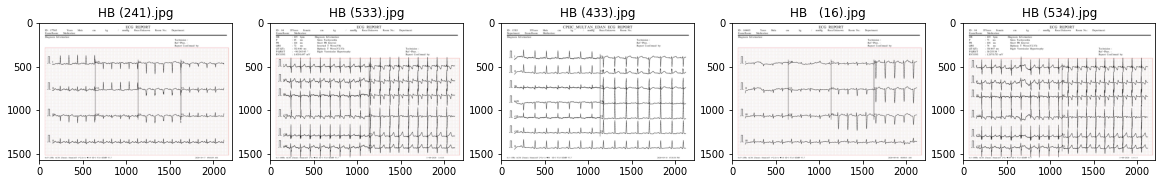

In [ ]:
# displaying random five images from one of the folders
plt.figure(figsize=(20,20))
test_folder=r'/content/drive/My Drive/Colab Notebooks/Project/Datasets/Abnormal HB/'
for i in range(5):
  file = random.choice(os.listdir('/content/drive/My Drive/Colab Notebooks/Project/Datasets/Abnormal HB/'))
  image_path= os.path.join('/content/drive/My Drive/Colab Notebooks/Project/Datasets/Abnormal HB/', file)
  img=mpimg.imread(image_path)
  ax=plt.subplot(1,5,i+1)
  ax.title.set_text(file)
  plt.imshow(img)

In [ ]:
#setting image dimensions and source folder for loading the dataset
img_width = 224
img_height = 224
img_folder = r'/content/drive/My Drive/Colab Notebooks/Project/Datasets/'
#creating the image dataset and labels from images in the folder
#source folder is the input parameter containing images from different classes
def create_dataset(img_folder):
  img_data_array = []
  class_name = []

  for dir1 in os.listdir(img_folder):
    for file in os.listdir(os.path.join(img_folder, dir1)):
      image_path = os.path.join(img_folder, dir1, file)
      image = cv2.imread(image_path, cv2.COLOR_BGR2RGB) #read image and convert to the right color format
      image = cv2.resize(image, (img_height, img_width), interpolation = cv2.INTER_AREA) #resize the image based on input dimensions
      image = np.array(image) #convert the image to numpy array
      image = image.astype('float32') # normalize the image
      image /= 255
      img_data_array.append(image)
      class_name.append(dir1)
  return img_data_array, class_name
#extract image array and class name
img_data_array, class_name = create_dataset(r'/content/drive/My Drive/Colab Notebooks/Project/Datasets/')

In [ ]:
#storing the images and their classes in a dataframe
data = pd.DataFrame()
data['image'] = img_data_array
data['class'] = class_name
#converting dataframe in a csv file
data.to_csv(r'/content/drive/My Drive/Colab Notebooks/Project/Datasets/imagedata.csv', header = True, index = False)

In [ ]:
#visualize the data
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project/Datasets/imagedata.csv')
train.head()

,image,class
0,[[[1. 1. 1.]\n [1. 1. 1.]\n [1. 1. 1.]\n .....,Normal Person
1,[[[1. 1. 1.]\n [1. 1. 1.]\n [1. 1. 1.]\n .....,Normal Person
2,[[[1. 1. 1.]\n [1. 1. 1.]\n [1. 1. 1.]\n .....,Normal Person
3,[[[1. 1. 1.]\n [1. 1. 1.]\n [1. 1. 1.]\n .....,Normal Person
4,[[[1. 1. 1.]\n [1. 1. 1.]\n [1. 1. 1.]\n .....,Normal Person


In [ ]:
#convert  text labels to numeric codes
#create a dictionary for all unique values for the classes
target_dict = {k: v for v, k in enumerate(np.unique(class_name))}
target_dict

{'Abnormal HB': 0, 'COVID-19': 1, 'HMI': 2, 'MI': 3, 'Normal Person': 4}

In [ ]:
train.shape


(2683, 2)

In [ ]:
#read the extracted images and convert them to numpy arrays
#create an empty list
train_images = []
#read and store the images
for i in tqdm(range(train.shape[0])):
  #loading the image amd keeping the target size as (224,224,3)
  image = cv2.imread(image_path, cv2.COLOR_BGR2RGB) 
  image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
  #normalizing the pixel value
  image = image.astype('float32')
  image /= 255
  #appending the image to the train_images list
  train_images.append(image)
#convert the list to numpy array
X = np.array(train_images)


100%|██████████| 2683/2683 [03:43<00:00, 12.00it/s]


In [ ]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.utils.vis_utils import plot_model
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [ ]:
vgg19= keras.applications.vgg19
vgg = vgg19.VGG19(weights='imagenet', include_top = False)

In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
print(np.min(X), np.max(X))

0.007843138 1.0


In [ ]:
print(X.shape)

(2683, 224, 224, 3)


In [ ]:
#expand the shape of the array
#new axis is added at the beginning 
Xs = np.expand_dims(X, axis = 0)
print(Xs.shape)

(1, 2683, 224, 224, 3)


In [ ]:
#preprocess the input array for VGG19
Xs = vgg19.preprocess_input(X)

In [ ]:
#evaluate model to extract features
features = vgg.predict(Xs)
print(features.shape)

(2683, 7, 7, 512)


In [ ]:
#creating a validation set
#separating the target
Y = train['class']
#creating the training / validation set
Xs_train, Xs_test, Y_train, Y_test = train_test_split(Xs,Y, random_state = 42, test_size = 0.2, stratify = Y)

In [ ]:
#Create dummies of target variable for train and validation
Y_train = pd.get_dummies(Y_train)
Y_test = pd.get_dummies(Y_test)

In [ ]:
vgg = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [ ]:
for layer in vgg.layers: 
  layer.trainable = False
x = keras.layers.Flatten()(vgg.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(5, activation='softmax')(x)
full_model = keras.models.Model(inputs=vgg.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])
history = full_model.fit(
    Xs_train, Y_train.values, 
    validation_data =(Xs_test, Y_test.values),
     batch_size = 32,
    epochs=5
)

Epoch 1/5
68/68 [==============================] - 1729s 25s/step - loss: 0.4735 - acc: 0.4105 - val_loss: 0.4600 - val_acc: 0.4264
Epoch 2/5
68/68 [==============================] - 1726s 25s/step - loss: 0.4625 - acc: 0.4259 - val_loss: 0.4608 - val_acc: 0.4264
Epoch 3/5
68/68 [==============================] - 1726s 25s/step - loss: 0.4629 - acc: 0.4259 - val_loss: 0.4628 - val_acc: 0.4264
Epoch 4/5
68/68 [==============================] - 1719s 25s/step - loss: 0.4630 - acc: 0.4259 - val_loss: 0.4597 - val_acc: 0.4264
Epoch 5/5
68/68 [==============================] - 1729s 26s/step - loss: 0.4612 - acc: 0.4259 - val_loss: 0.4586 - val_acc: 0.4264


In [ ]:
full_model.save('/content/drive/My Drive/Colab Notebooks/Project/model.h5')

In [ ]:
_, accuracy = full_model.evaluate(Xs_test, Y_test)
print("Accuracy: %.2f"% (accuracy*100))

In [ ]:
# Visualize the train and test losses
plt.title("Training Loss vs Validation Loss")
plt.plot(epochs, history["loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# Visualize Accuracy for train and validation sets
plt.title("Training Accuracy vs Validation Accuracy")
plt.plot(epochs, history["accuracy"], label="Train Accuracy")
plt.plot(epochs, history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
#
image_path = '/content/drive/My Drive/Colab Notebooks/Project/Datasets/MI/MI (38).jpg '
img = process_image(image_path)
img_pred = full_model.predict(img)
class_pred = target_dict(img_pred)

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(plt.imread(image_path))
plt.title(format_name(class_pred))
plt.show()